In [7]:
# Data processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os, os.path
import random

import mne

# Model buidling
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import r2_score, plot_roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier


print(__doc__)

Automatically created module for IPython interactive environment


In [4]:
random.seed(123)
print('Loading dataset...')

eeg_data = pd.read_csv('eeg_data_pca2.csv')
df_r = eeg_data.drop(labels=['Unnamed: 0','.id','.sample'], axis=1)

print('Simulating data...')

def simulate(df, feature):
    sim_data = []
    sim_min = min(df[feature])
    sim_max = max(df[feature])
    
    [sim_data.append(round(random.uniform(sim_min, sim_max), 16)) for x in range(len(df))]
    
    return sim_data
    
sl_noun_pred_2_sim = simulate(df_r, 'sl_noun_pred_2')
random.shuffle(sl_noun_pred_2_sim)

subject_sim = []

for s in df_r['subject']:
    subject_sim.append(s+110)
    
df_sim = df_r.copy()
df_sim = df_sim.drop(labels=['sl_noun_pred_2', 'subject'], axis=1)
df_sim.insert(2, 'sl_noun_pred_2', sl_noun_pred_2_sim)
df_sim.insert(3, 'subject', subject_sim)

print('Preparing data for classification...')

df_merge = pd.concat([df_r, df_sim])

df_merge['idx'] = df_merge.groupby('subject').cumcount()

tmp = []
for var in ['PC1','PC2','sl_noun_pred_2']:
    df_merge['tmp_idx'] = var + '_' + df_merge.idx.astype(str)
    tmp.append(df_merge.pivot(index='subject',columns='tmp_idx',values=var))

df = pd.concat(tmp,axis=1)

df = df.interpolate(method='linear', axis=0)

df.insert(len(df.columns), 'label', 'conscious')
for s in df.index:
    if s > 110:
        df['label'][s] = 'unconscious'

print('Complete.')
print()

df

Loading dataset...
Simulating data...
Preparing data for classification...
Complete.



<ipython-input-4-ef049a28c915>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][s] = 'unconscious'


tmp_idx,PC1_0,PC1_1,PC1_10,PC1_100,PC1_1000,PC1_10000,PC1_10001,PC1_10002,PC1_10003,PC1_10004,...,sl_noun_pred_2_9991,sl_noun_pred_2_9992,sl_noun_pred_2_9993,sl_noun_pred_2_9994,sl_noun_pred_2_9995,sl_noun_pred_2_9996,sl_noun_pred_2_9997,sl_noun_pred_2_9998,sl_noun_pred_2_9999,label
subject,,,,,,,,,,,,,,,,,,,,,
0,-3.767287,1.914585,-11.938799,33.031513,13.568619,-56.761652,-56.964403,-38.968334,-18.991623,-12.928979,...,1.046544,1.046544,1.294623,1.294623,1.294623,-1.523383,-1.523383,-1.523383,-1.523383,conscious
1,-14.672427,1.872790,22.950736,23.153696,-18.327757,16.990367,0.276509,-13.840077,-17.332725,-15.464355,...,1.196434,1.196434,1.196434,1.196434,1.196434,1.196434,1.196434,1.144289,1.144289,conscious
2,-55.485143,-54.486451,-14.556419,11.168614,-24.676368,-21.226704,-17.665273,-9.520939,-2.640338,1.629307,...,-1.562209,-1.562209,-1.562209,-1.562209,-1.562209,1.088983,1.088983,1.088983,1.088983,conscious
3,-49.925503,-60.282358,-72.278523,-4.162947,-20.800854,15.729631,-22.031752,-44.672156,-59.159583,-78.441313,...,0.947114,-0.891039,-0.891039,-0.891039,-0.891039,-0.891039,1.209560,1.209560,1.209560,conscious
4,-2.502172,-1.813652,-33.190475,0.968469,-33.913475,0.950472,23.868143,41.725653,21.701927,10.196998,...,-1.523383,-1.523383,-0.891039,-0.891039,-0.891039,-0.891039,-0.891039,-1.482830,-1.482830,conscious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,-15.974010,-10.110420,5.266637,-37.577600,-51.921470,-16.944940,-18.984670,-23.389780,-29.282950,-32.557260,...,1.215335,-1.416907,-0.804911,0.713910,-1.301128,0.725029,-1.219916,-0.918834,0.931523,unconscious
217,-39.233590,-46.351880,9.111469,19.044060,-15.445360,-11.690430,-0.712780,-11.256360,-29.278400,-35.168310,...,0.431432,1.288160,1.155018,0.779057,-1.263075,-0.059080,1.048379,-0.817337,-0.679265,unconscious
218,-18.647160,-24.240630,11.493300,10.776270,-59.773050,-6.404577,3.908406,6.441168,4.379888,3.558150,...,0.247066,-0.016467,-1.206224,0.323651,-0.174804,-0.409402,-1.233577,-1.173858,0.345142,unconscious


In [27]:
# SVM
print('One hot encoding labels and filling missing values...')
random.seed(123)

df_svm = df.iloc[:,:-1].apply(pd.to_numeric)
df_svm = df_svm.fillna(0)

df_svm.insert(len(df_svm.columns), 'label', 'conscious')
for s in df_svm.index:
    if s > 110:
        df_svm['label'][s] = 'unconscious'

print('Splitting data into 60/40 train and test set...')

features = df_svm.iloc[:,:-1]
labels = df_svm.iloc[:,-1]
labels = [0 if label == 'conscious' else 1 for label in labels]

X_train, X_test, y_train, y_test = train_test_split(features,labels,stratify = 
                                                  labels, train_size = 0.6, test_size = 0.4,
                                                  random_state=6,shuffle=True)

print('Setting up Support Vector Machine...')
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

svc = svm.SVC(kernel='linear', C=1, gamma=0.9)

print('Training model with k=5 cross validation')
scores = cross_val_score(svc, X_train_transformed, y_train, cv=5)
y_pred = cross_val_predict(lasso, X, y, cv=3)

svc.fit(scores)

print('Predicting on test set...')
print()
y_pred = svc.predict(X_test_transformed)
print('Prediction complete:')
print("\t Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("\t Precision:", metrics.precision_score(y_test, y_pred))
print("\t Recall:", metrics.recall_score(y_test, y_pred))
print()
svc_disp = plot_roc_curve(svc, X_test_transformed, y_test)
plt.show()
print()
print(classification_report(y_test, y_pred))

One hot encoding labels and filling missing values...


<ipython-input-27-dc4ef5c7b6e7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_svm['label'][s] = 'unconscious'


Splitting data into 60/40 train and test set...
Setting up Support Vector Machine...
Training model with k=5 cross validation


TypeError: fit() missing 1 required positional argument: 'y'

In [28]:
scores

array([1., 1., 1., 1., 1.])

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [38]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


cat_cols = X_train.columns[X_train.dtypes == 'O']
num_cols = X_train.columns[X_train.dtypes == 'float64']

categories = [
    X_train[column].unique() for column in X_train[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

cat_proc_nlin = make_pipeline(
    SimpleImputer(missing_values=None, strategy='constant',
                  fill_value='missing'),
    OrdinalEncoder(categories=categories)
    )

num_proc_nlin = make_pipeline(SimpleImputer(strategy='mean'))

cat_proc_lin = make_pipeline(
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OneHotEncoder(categories=categories)
)

num_proc_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# transformation to use for non-linear estimators
processor_nlin = make_column_transformer(
    (cat_proc_nlin, cat_cols),
    (num_proc_nlin, num_cols),
    remainder='passthrough')

# transformation to use for linear estimators
processor_lin = make_column_transformer(
    (cat_proc_lin, cat_cols),
    (num_proc_lin, num_cols),
    remainder='passthrough')

In [63]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

svm_pipeline = make_pipeline(processor_lin, SVC())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))


estimators = [('SVM', svm_pipeline),
             ('Random Forest', rf_pipeline)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

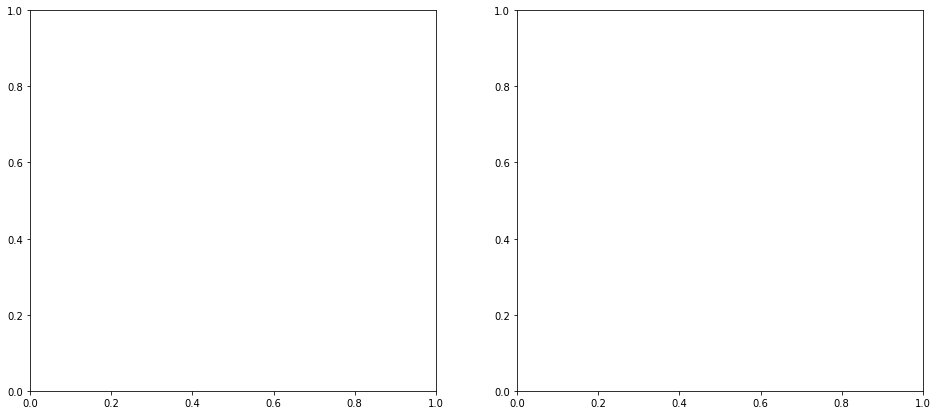

In [83]:
fig, axs = plt.subplots(1,2, figsize=(16,7))
axs = np.ravel(axs)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

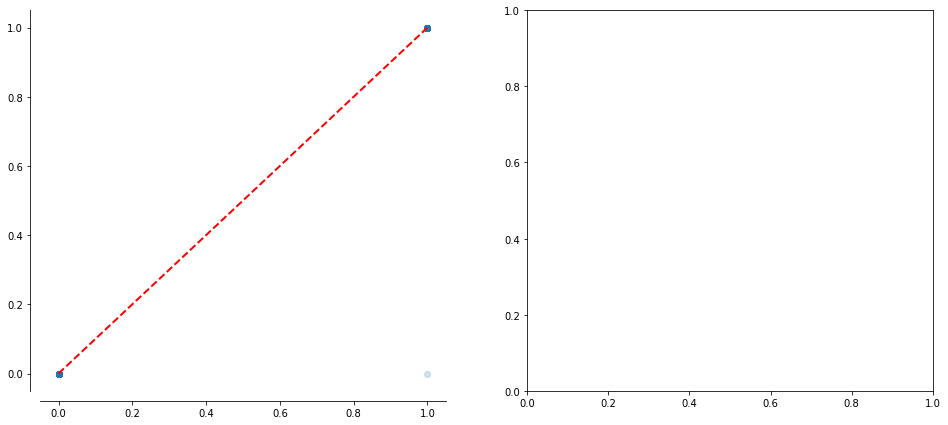

In [84]:
fig, axs = plt.subplots(1,2, figsize=(16, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X_train, y_train,
                           scoring=['recall_macro', 'precision_macro'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)
    
    plot_regression_results(
        ax, y_train, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_precision_macro']),
                np.std(score['test_precision_macro']),
                -np.mean(score['test_recall_macro']),
                np.std(score['test_recall_macro'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [68]:
type(y_pred)

numpy.ndarray

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {EXIT(1)}

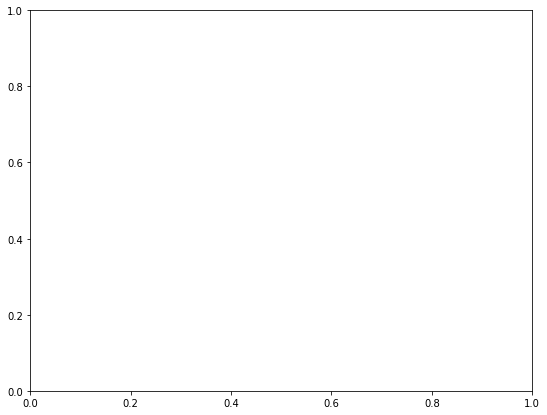

In [64]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(1, figsize=(9, 7))
axs = np.ravel(axs)


for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X_train, y_train,
                           scoring=['recall_macro', 'precision_macro'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y_train, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_precision_macro']),
                np.std(score['test_precision_macro']),
                -np.mean(score['test_recall_macro']),
                np.std(score['test_recall_macro'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

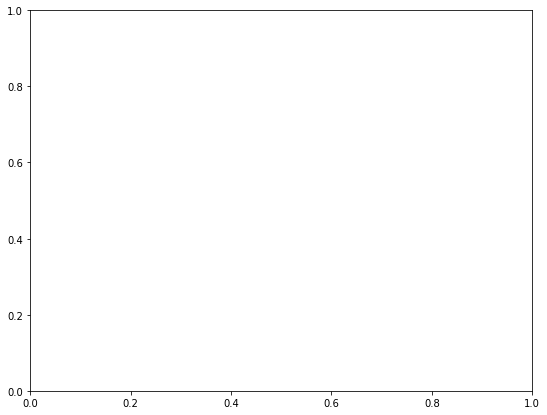

In [62]:
fig, axs = plt.subplots(1, figsize=(9, 7))
axs = np.ravel(axs)

plt.show()

Initialising random forest...
Prediction complete:
	 Accuracy: 0.9887640449438202
	 Precision: 0.9777777777777777
	 Recall: 1.0


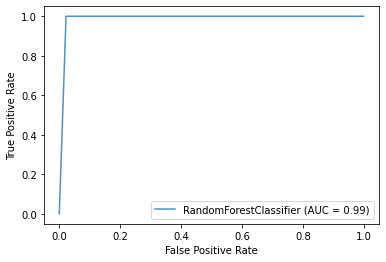

In [68]:
print('Initialising random forest...')
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print('Prediction complete:')
print("\t Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("\t Precision:", metrics.precision_score(y_test, y_pred))
print("\t Recall:", metrics.recall_score(y_test, y_pred))

ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()